In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 12})

from matplotlib import font_manager
font_manager.fontManager.addfont('../misc/lucida-sans-unicode.ttf')

import seaborn as sns
tregs.mpl_pboc.plotting_style()

{'green': '#7AA974',
 'light_green': '#BFD598',
 'pale_green': '#DCECCB',
 'yellow': '#EAC264',
 'light_yellow': '#F3DAA9',
 'pale_yellow': '#FFEDCE',
 'blue': '#738FC1',
 'light_blue': '#A9BFE3',
 'pale_blue': '#C9D7EE',
 'red': '#D56C55',
 'light_red': '#E8B19D',
 'pale_red': '#F1D4C9',
 'purple': '#AB85AC',
 'light_purple': '#D4C2D9',
 'dark_green': '#7E9D90',
 'dark_brown': '#905426'}

**Does competing sites ever lead to bad signal?**

Let's re-do the case study on simple repression by lacI. This time, instead of placing the lacI binding site downstream of the RNAP binding site, we place the lacI binding site at the -10 binding site of RNAP

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

In [4]:
original_rep_site = 'AATTGTGAGCGGATAACAATT'
print('The length of the original repressor binding site is {}.'.format(len(original_rep_site)))

The length of the original repressor binding site is 21.


In [5]:
# Alternative repressor binding site
rep_site = rnap_site[(len(rnap_site) - len(original_rep_site)):(len(rnap_site))]

## Find the transcription start site
df = pd.read_csv('../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

### Assuming the the repressor has the same energy matrix has the RNAP

First we assume that the LacI repressor has the exact same energy matrix as the RNA polymerase.

In [6]:
def plot_footprint(df, rep_start_site):
    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']

    nbins = 2
    upper_bound = np.mean(mu_data)
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                pseudocount=0)
    exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                        smoothed=True, windowsize=3)

    fig, ax = plt.subplots(figsize=(12,3))

    ax.axvspan(-38, -30, alpha=0.7, color='#A9BFE3')
    ax.axvspan(rep_start_site, rep_start_site + 18, alpha=0.7, color='#E8B19D')
    ax.axvspan(-15, -5, alpha=0.7, color='#A9BFE3')


    ax.set_ylim(top=max(footprint)*1.15)
    ax.add_patch(mpl.patches.Rectangle((-38, max(footprint)*1.15),
                                            8,
                                            max(footprint) * 0.2,
                                            facecolor='#738FC1',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-38 + 0.5 * 8, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
            ha='center', va='baseline')

    ax.add_patch(mpl.patches.Rectangle((-15, max(footprint)*1.15),
                                            10,
                                            max(footprint) * 0.2,
                                            facecolor='#738FC1',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-15 + 0.5 * 10, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
            ha='center', va='baseline')

    ax.add_patch(mpl.patches.Rectangle((rep_start_site, max(footprint)*1.35),
                                            18,
                                            max(footprint) * 0.2,
                                            facecolor='#D56C55',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(rep_start_site + 0.5 * 18, max(footprint) * 1.4, 'LacI', fontsize = 10, color = 'k',
            ha='center', va='baseline')


    windowsize=3
    cut = int((windowsize - 1) / 2)
    x = np.arange(-115 + cut, 45 - cut)
    shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]
    ax.bar(x, footprint, color=shiftcolors, edgecolor=None, linewidth=0)
    ax.set_ylabel('Information (bits)', fontsize=12)

    custom_lines = [Line2D([0], [0], color='#D56C55', lw=4),
                    Line2D([0], [0], color='#738FC1', lw=4)]
    plt.legend(custom_lines,
            ['Mutation\nincreases\nexpression', 'Mutation\ndecreases\nexpression'],
            bbox_to_anchor=(1.2, 0.95), frameon=False)

    plt.tight_layout()
    #plt.savefig('../figs/simrep_footprint_overlapping.png', dpi=300, bbox_inches='tight')
    plt.show()

In [7]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

rep_emat = rnap_emat[(len(rnap_site) - len(original_rep_site)):(len(rnap_site))]

In [8]:
promoter.find(rep_site) - 115

-21

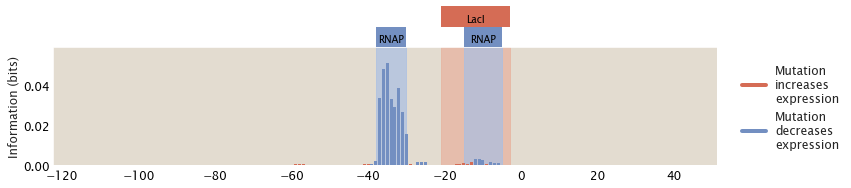

In [9]:
n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)
plot_footprint(df, -21)

### Generating random energy matrix for the repressor with the correct sequence specificity

In [10]:
def generate_emap(seq, fixed=False,
                  fixed_value=1,
                  max_mut_energy=0.5):
    nt_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    emat = np.zeros((4, len(seq)))
    for i,nt in enumerate(seq):
        for j in range(4):
            if j != nt_index[nt]:
                if fixed:
                    emat[j, i] = fixed_value
                else:
                    emat[j, i] = np.random.uniform(low=0.1, high=max_mut_energy)
    
    return emat

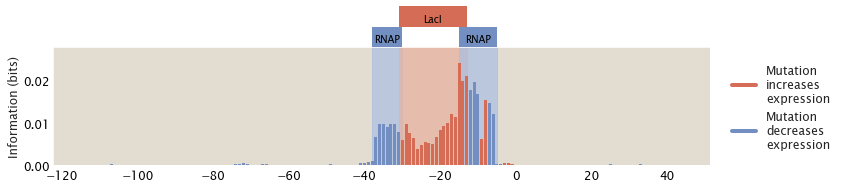

In [11]:
rep_site = rnap_site[(len(rnap_site) - len(original_rep_site) - 10):(len(rnap_site) - 10)]
rep_emat = generate_emap(rep_site, fixed=True, fixed_value=1)

n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)
plot_footprint(df, promoter.find(rep_site) - 115)

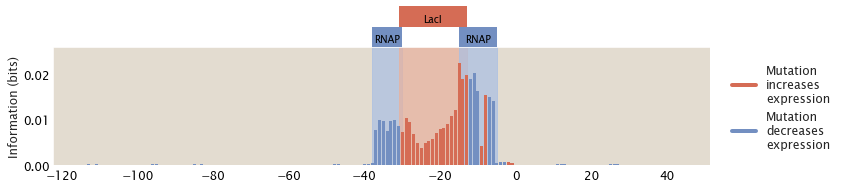

In [12]:
rep_site = rnap_site[(len(rnap_site) - len(original_rep_site) - 10):(len(rnap_site) - 10)]
rep_emat = generate_emap(rep_site, fixed=True, fixed_value=1)

n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)
plot_footprint(df, promoter.find(rep_site) - 115)

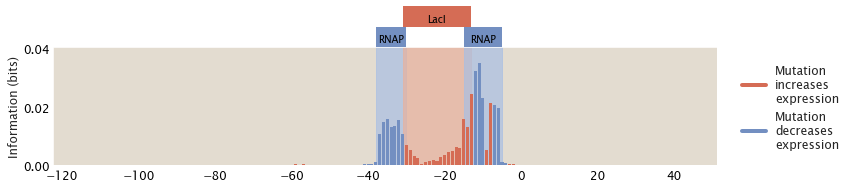

In [13]:
rep_site = rnap_site[(len(rnap_site) - len(original_rep_site) - 10):(len(rnap_site) - 10)]
rep_emat = generate_emap(rep_site, fixed=True, fixed_value=3)

n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)
plot_footprint(df, promoter.find(rep_site) - 115)

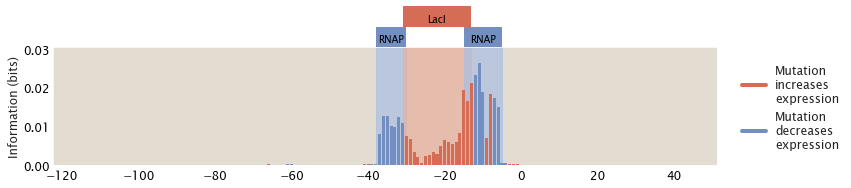

In [14]:
rep_site = rnap_site[(len(rnap_site) - len(original_rep_site) - 10):(len(rnap_site) - 10)]
rep_emat = generate_emap(rep_site, fixed=False, max_mut_energy=0.5)

n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)
plot_footprint(df, promoter.find(rep_site) - 115)

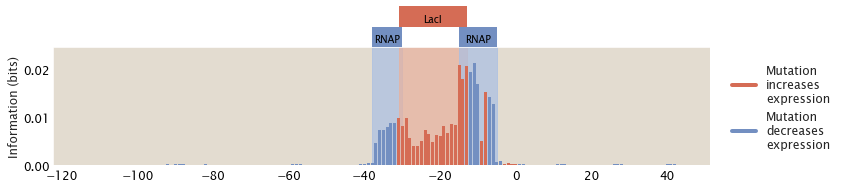

In [15]:
rep_site = rnap_site[(len(rnap_site) - len(original_rep_site) - 10):(len(rnap_site) - 10)]
rep_emat = generate_emap(rep_site, fixed=False, max_mut_energy=1)

n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)
plot_footprint(df, promoter.find(rep_site) - 115)

### Engineering an energy matrix for the repressor that is different than the RNAP energy matrix but preserve the sequence specificity

In [16]:
def generate_emap(seq, max_mut_energy):
    nt_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    emat = np.zeros((4, len(seq)))
    for i,nt in enumerate(seq):
        for j in range(4):
            if j != nt_index[nt]:
                emat[j, i] = np.random.uniform(low=0.1, high=max_mut_energy)
    
    return emat

In [17]:
def plot_footprint(df, wtseq, rnap_wtseq, rep_wtseq, nbins, bin_boundary):
    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']

    upper_bound = np.mean(mu_data) * bin_boundary
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                pseudocount=0)
    exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                        smoothed=True, windowsize=3)

    fig, ax = plt.subplots(figsize=(10, 2))
    ax.set_xlabel('position')
    ax.set_ylabel('Mutual information (bits)')

    rnap_start, rnap_end = tregs.seq_utils.find_binding_site(wtseq, rnap_wtseq)
    rep_start, rep_end = tregs.seq_utils.find_binding_site(wtseq, rep_wtseq)
    ax.axvspan(rnap_start-116, rnap_end-116, alpha=0.5, color='#A9BFE3')
    ax.axvspan(rep_start-116, rep_end-116, alpha=0.5, color='#E8B19D')

    windowsize = 3
    cut = int((windowsize - 1) / 2)
    x = np.arange(-115 + cut, 45 - cut)
    shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]
    ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

    plt.show()

In [18]:
_genome = []
for record in SeqIO.parse("../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

df = pd.read_csv('../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [19]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
original_rep_site = 'AATTGTGAGCGGATAACAATT'

rnap_emat = generate_emap(rnap_site, 1)
rep_emat = generate_emap(original_rep_site, 1)

n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, original_rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)

plot_footprint(df, promoter, rnap_site, original_rep_site)

TypeError: plot_footprint() missing 2 required positional arguments: 'nbins' and 'bin_boundary'

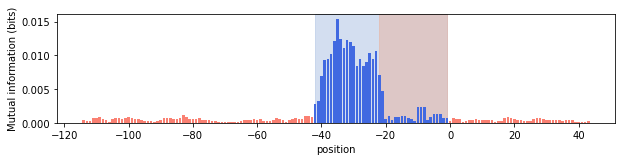

In [ ]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = rnap_site[(len(rnap_site) - len(original_rep_site)):]

rnap_emat = generate_emap(rnap_site, 2)
rep_emat = rnap_emat[:, (len(rnap_site) - len(original_rep_site)):]

n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)

plot_footprint(df, promoter, rnap_site, rep_site)

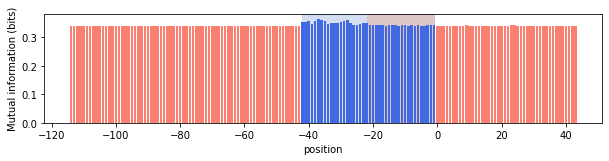

In [ ]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = rnap_site[(len(rnap_site) - len(original_rep_site)):]

rnap_emat = generate_emap(rnap_site, 2)
rep_emat = rnap_emat[:, (len(rnap_site) - len(original_rep_site)):]

n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)

plot_footprint(df, promoter, rnap_site, rep_site, nbins=3, bin_boundary=1)

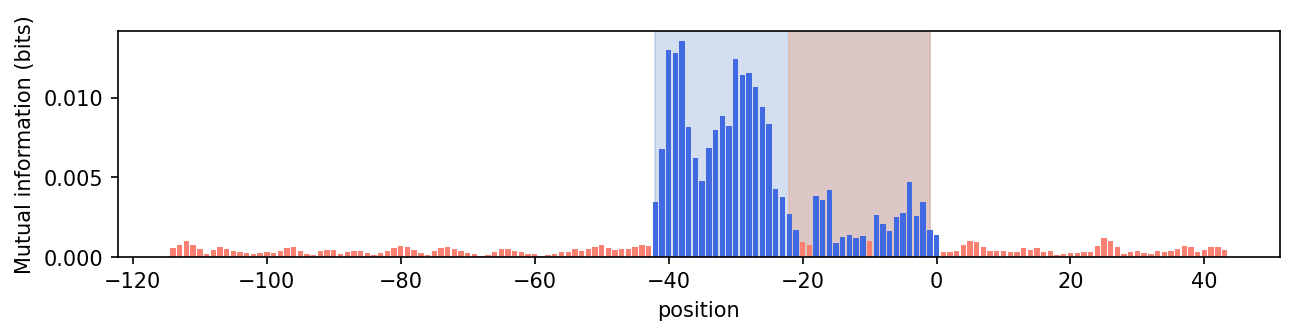

In [ ]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = rnap_site[(len(rnap_site) - len(original_rep_site)):]

rnap_emat = generate_emap(rnap_site, 2)
rep_emat = generate_emap(rep_site, 2)

n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)

plot_footprint(df, promoter, rnap_site, rep_site)

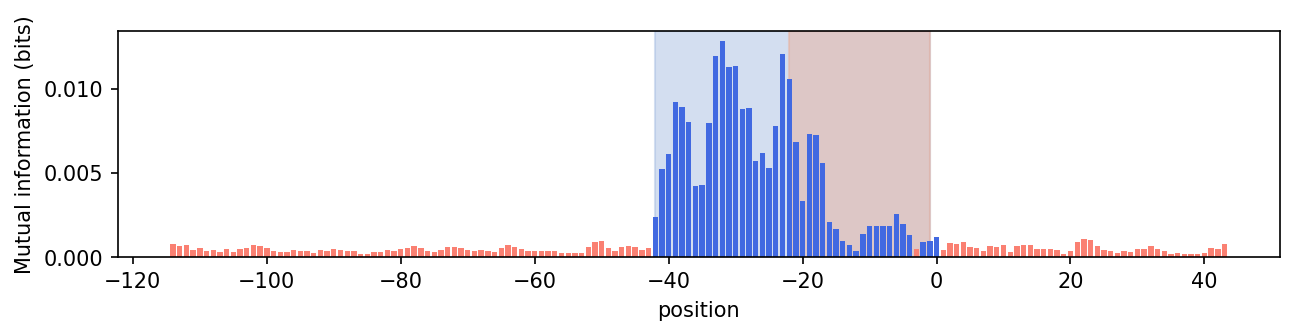

In [ ]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = rnap_site[(len(rnap_site) - len(original_rep_site)):]

rnap_emat = generate_emap(rnap_site, 2)
rep_emat = generate_emap(rep_site, 2)

n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)

plot_footprint(df, promoter, rnap_site, rep_site)

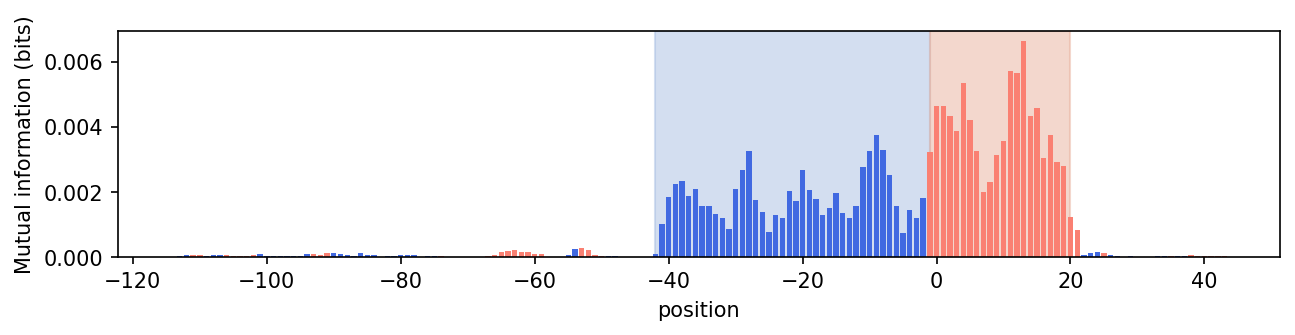

In [ ]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

rnap_emat = generate_emap(rnap_site, 1)
rep_emat = generate_emap(original_rep_site, 1)

n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 500

df = tregs.simulate.simrep(promoter, rnap_site, original_rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)

plot_footprint(df, promoter, rnap_site, original_rep_site)

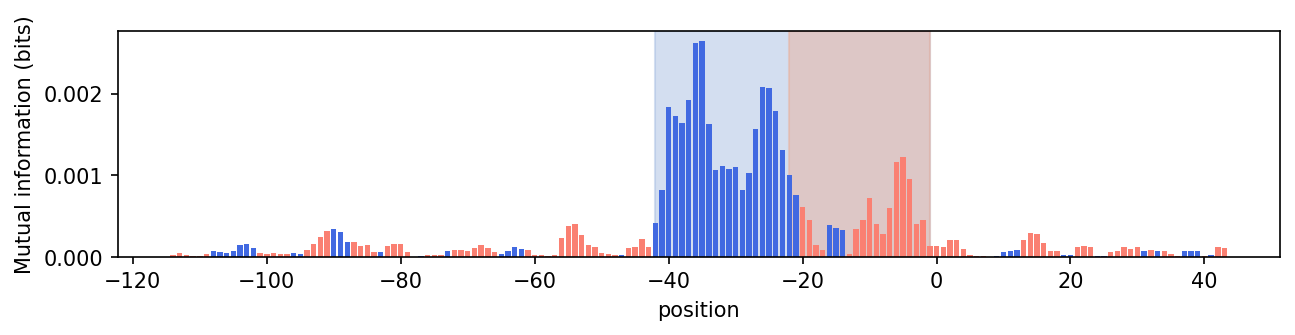

In [ ]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = rnap_site[(len(rnap_site) - len(original_rep_site)):]

rnap_emat = generate_emap(rnap_site, 1)
rep_emat = generate_emap(rep_site, 1)

n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 500

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)

plot_footprint(df, promoter, rnap_site, rep_site)

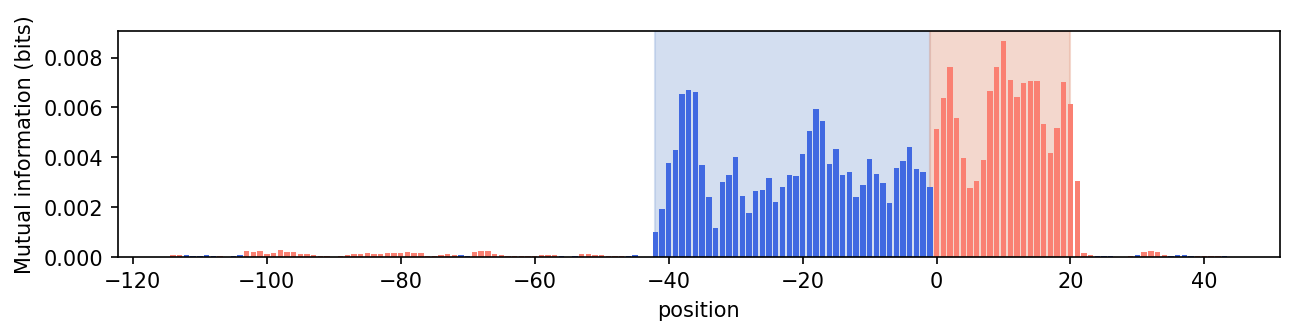

In [ ]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

rnap_emat = generate_emap(rnap_site, 1)
rep_emat = generate_emap(original_rep_site, 1)

n_NS = len(genome)
ep_wt, er_wt = -5, -17
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, original_rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)

plot_footprint(df, promoter, rnap_site, original_rep_site)

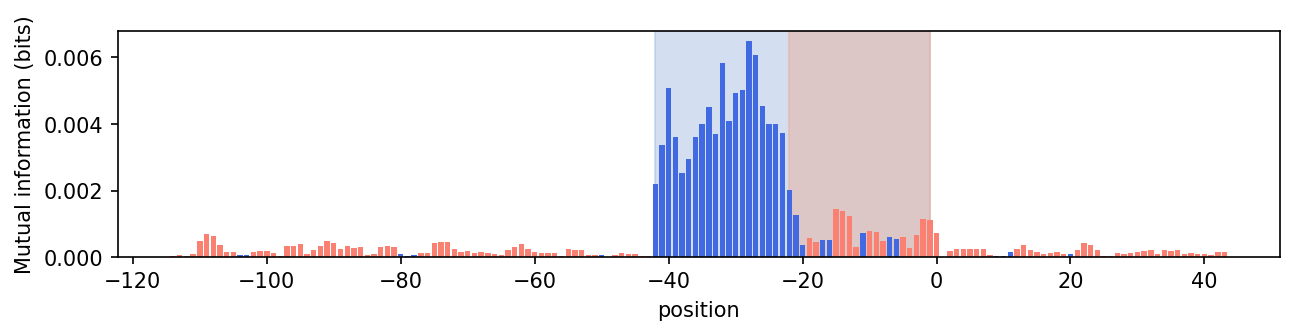

In [ ]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = rnap_site[(len(rnap_site) - len(original_rep_site)):]

rnap_emat = generate_emap(rnap_site, 1)
rep_emat = generate_emap(rep_site, 1)

n_NS = len(genome)
ep_wt, er_wt = -5, -17
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)

plot_footprint(df, promoter, rnap_site, rep_site)

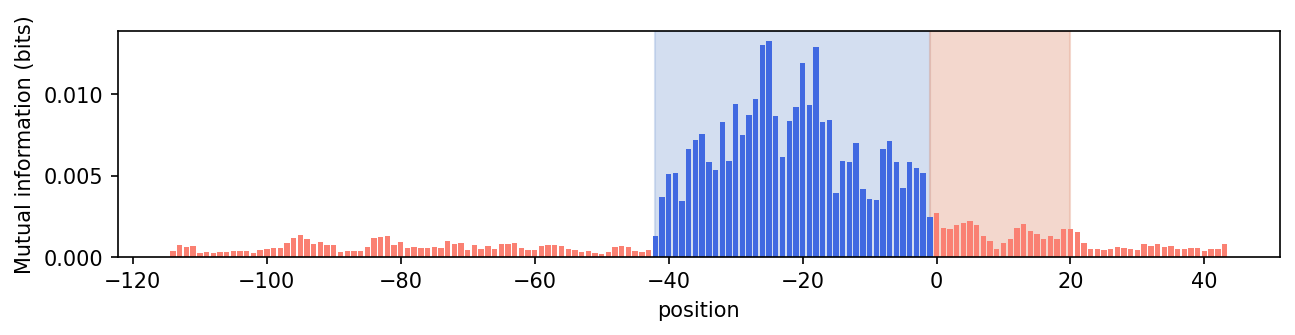

In [ ]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

rnap_emat = generate_emap(rnap_site, 1)
rep_emat = generate_emap(original_rep_site, 1)

n_NS = len(genome)
ep_wt, er_wt = -5, -12
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, original_rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)

plot_footprint(df, promoter, rnap_site, original_rep_site)

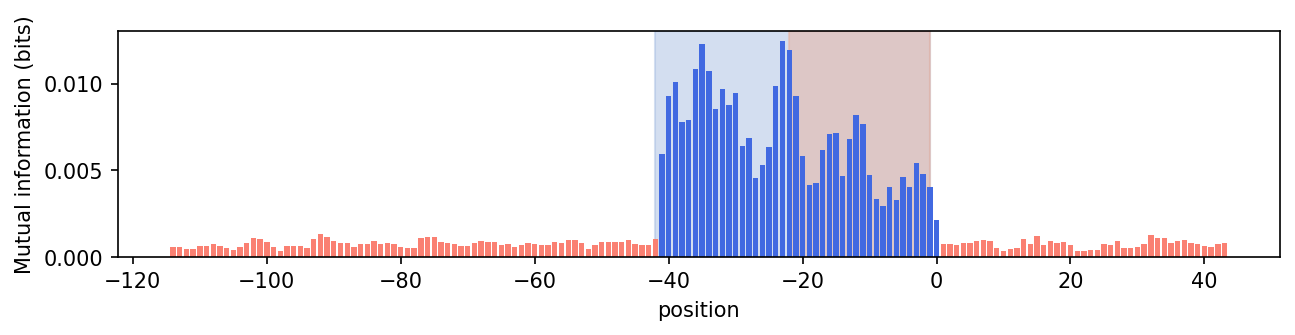

In [ ]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = rnap_site[(len(rnap_site) - len(original_rep_site)):]

rnap_emat = generate_emap(rnap_site, 1)
rep_emat = generate_emap(rep_site, 1)

n_NS = len(genome)
ep_wt, er_wt = -5, -12
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)

plot_footprint(df, promoter, rnap_site, rep_site)